In [29]:
import glob
import pickle
import tqdm
import torch
import matplotlib.pyplot as plt
from ray_optim.plot import Plot
%matplotlib inline
from ray_nn.nn.xy_hist_data_models import MetrixXYHistSurrogate, StandardizeXYHist, HistSurrogateEngine
from ray_tools.base.backend import RayBackendDockerRAYUI
from ray_tools.base.transform import MultiLayer
from ray_tools.base.engine import RayEngine
from ray_nn.data.lightning_data_module import DefaultDataModule
from datasets.metrix_simulation.config_ray_emergency_surrogate import PARAM_CONTAINER_FUNC as params
from datasets.metrix_simulation.config_ray_emergency_surrogate import TRANSFORMS as cfg_transforms
from ray_tools.base.parameter import NumericalParameter, NumericalOutputParameter, RayParameterContainer
from ray_tools.simulation.torch_datasets import BalancedMemoryDataset, MemoryDataset, RayDataset
from sub_projects.ray_optimization.utils import ray_output_to_tensor
from sub_projects.ray_optimization.ray_optimization import RayOptimization
from ray_optim.ray_optimizer import RayOptimizer
from ray_tools.base.utils import RandomGenerator
from sub_projects.ray_optimization.real_data import import_data
from ray_tools.base.transform import XYHistogram

# Model

In [2]:
def tensor_to_param_container(ten):
    param_dict = {}
    for i, (label, entry) in enumerate(params().items()):
        if label == 'U41_318eV.numberRays':
            param_dict[label] = entry
        else:
            value = ten[i-1]*(entry.value_lims[1]-entry.value_lims[0])+entry.value_lims[0]
            param_dict[label] = NumericalParameter(value.item())
            if value.item() < entry.value_lims[0] or value.item() > entry.value_lims[1]:
                if value.item() < entry.value_lims[0]:
                    value = torch.ones_like(value) * entry.value_lims[0]
                elif value.item() > entry.value_lims[1]:
                    value = torch.ones_like(value) * entry.value_lims[1]
                #raise Exception("Out of range. Minimum was {}, maximum {} but value {}. Tensor value was {}.".format(entry.value_lims[0], entry.value_lims[1], value.item(), ten[i-1].item()))
    return RayParameterContainer(param_dict)
def mse_engines_comparison(engine, surrogate_engine, param_container_list: list[RayParameterContainer], transforms):
    out = engine.run(param_container_list, transforms)
    out_surrogate = surrogate_engine.run(param_container_list, transforms)
    std_backward = surrogate_engine.model.standardizer.destandardize
    x_simulation_hist_list = []
    y_simulation_hist_list = []
    mse_list = []
    for i in range(len(out_surrogate)):
        surrogate_hist = out_surrogate[i]['ray_output']['ImagePlane']['xy_hist']
        out_simulation = out[i]['ray_output']['ImagePlane']['0.0']
        x_simulation_hist, _ = torch.histogram(out_simulation.x_loc,bins=50, range=[-10, 10])
        x_simulation_hist_list.append(x_simulation_hist)
        y_simulation_hist, _ = torch.histogram(out_simulation.y_loc,bins=50, range=[-3, 3])
        y_simulation_hist_list.append(y_simulation_hist)
        mse = ((torch.stack([std_backward(surrogate_hist.x_loc), std_backward(surrogate_hist.y_loc)]) - torch.stack([x_simulation_hist, y_simulation_hist]))**2).mean()
        mse_list.append(mse)
    return torch.stack(mse_list), x_simulation_hist_list, y_simulation_hist_list

In [3]:
engine = RayEngine(rml_basefile='rml_src/METRIX_U41_G1_H1_318eV_PS_MLearn_1.15.rml',
                                exported_planes=["ImagePlane"],
                                ray_backend=RayBackendDockerRAYUI(docker_image='ray-ui-service',
                                                                  docker_container_name='ray-ui-service-test',
                                                                  dockerfile_path='ray_docker/rayui',
                                                                  ray_workdir='/dev/shm/ray-workdir',
                                                                  verbose=False),
                                num_workers=-1,
                                as_generator=False)
surrogate_engine = HistSurrogateEngine(checkpoint_path="outputs/xy_hist/i7sryekx/checkpoints/epoch=174-step=42782950.ckpt")

Sequential(
  (0): Linear(in_features=34, out_features=68, bias=True)
  (1): Mish()
  (2): Linear(in_features=68, out_features=72, bias=True)
  (3): Mish()
  (4): Linear(in_features=72, out_features=77, bias=True)
  (5): Mish()
  (6): Linear(in_features=77, out_features=82, bias=True)
  (7): Mish()
  (8): Linear(in_features=82, out_features=87, bias=True)
  (9): Mish()
  (10): Linear(in_features=87, out_features=93, bias=True)
  (11): Mish()
  (12): Linear(in_features=93, out_features=100, bias=True)
  (13): Sigmoid()
)


In [ ]:
Plot.plot_engines_comparison(engine, surrogate_engine, [tensor_to_param_container(torch.ones((34))*0.5)], MultiLayer([0.]))

# Datamodule

In [ ]:
load_len: int | None = 10000
h5_files = list(glob.iglob('datasets/metrix_simulation/ray_emergency_surrogate/data_raw_*.h5'))
dataset = RayDataset(h5_files=h5_files,
                        sub_groups=['1e5/params',
                                    '1e5/ray_output/ImagePlane/histogram', '1e5/ray_output/ImagePlane/n_rays'], transform=Select(keys=['1e5/params', '1e5/ray_output/ImagePlane/histogram', '1e5/ray_output/ImagePlane/n_rays'], search_space=params(), non_dict_transform={'1e5/ray_output/ImagePlane/histogram': surrogate_engine.model.standardizer}))


bal_memory_dataset = BalancedMemoryDataset(dataset=dataset, load_len=load_len, min_n_rays=500)
memory_dataset = MemoryDataset(dataset=dataset, load_len=load_len)
datamodule = DefaultDataModule(dataset=bal_memory_dataset, num_workers=4)
datamodule.prepare_data()
datamodule.setup(stage="test")
test_dl = datamodule.test_dataloader()

unbal_datamodule = DefaultDataModule(dataset=memory_dataset, num_workers=4)
unbal_datamodule.prepare_data()
unbal_datamodule.setup(stage="test")
unbal_test_dl = unbal_datamodule.test_dataloader()

## Maximum distribution

In [ ]:
value_list = []
params_list = []

for i in tqdm.tqdm(unbal_test_dl):
    biggest = i[1].flatten(start_dim=1)
    biggest, _ = i[1].flatten(start_dim=1).max(dim=1)
    mask = biggest > 0.8
    value_list.append(biggest[mask])
    params_list.append(i[0][mask])
value_tensor = torch.cat(value_list)
params_tensor = torch.cat(params_list)

torch.save(value_tensor, 'outputs/values.pt')
torch.save(params_tensor, 'outputs/params.pt')
plt.hist(value_tensor)
plt.savefig('outputs/max_dist_hist.png')

In [ ]:
value_tensor = torch.load('outputs/values.pt')
params_tensor = torch.load('outputs/params.pt')

# Special sample

In [ ]:
with open("outputs/special_sample_168_selected.pkl", "rb") as f:
    special_sample = pickle.load(f, fix_imports=True, encoding='ASCII', errors='strict', buffers=None)
observed_params = special_sample.uncompensated_parameters

for param_container in observed_params:
    for label in ['ImagePlane.translationXerror', 'ImagePlane.translationYerror', 'ImagePlane.translationZerror']:
        if label in list(param_container.keys()):
            del param_container[label]

In [ ]:
len(observed_params)
Plot.plot_engines_comparison(engine, surrogate_engine, observed_params[:5], MultiLayer([0.]), )

In [ ]:
uncompensated_parameters = [elem.clone() for elem in special_sample.uncompensated_parameters]
for elem in uncompensated_parameters:
    elem.perturb(special_sample.target_params)
uncompensated_parameters[0]

In [ ]:
Plot.plot_engines_comparison(engine, surrogate_engine, uncompensated_parameters, MultiLayer([0.]))

In [ ]:
mse_comparison, x_simulation_hist, y_simulation_hist = mse_engines_comparison(engine, surrogate_engine, uncompensated_parameters[:5], MultiLayer([0.]))
plt.clf()
fig, ax = plt.subplots(1, 3)
for hist in x_simulation_hist:
    ax[0].plot(hist, alpha=0.3)
for hist in y_simulation_hist:
    ax[1].plot(hist, alpha=0.3)
ax[2].hist(mse_comparison)

In [ ]:
x_loc_list = []
good_param_list = []
batch_size = 5000
for i in tqdm.trange(15000//batch_size):
    param_container = [tensor_to_param_container(torch.rand((34,))) for _ in range(batch_size)]
    surrogate_out = surrogate_engine.run(param_container, MultiLayer([0.]))
    for j in range(len(param_container)):
        output = surrogate_out[j]['ray_output']['ImagePlane']['xy_hist']
        if output.x_loc.sum() > 0.5:
            x_loc_list.append(output.x_loc.sum())
            good_param_list.append(param_container[j])

observed_containers_tensor = torch.vstack([surrogate_engine.select({"1e5/params":param_container})[0] for param_container in observed_params])
good_containers_tensor = torch.vstack([surrogate_engine.select({"1e5/params":param_container})[0] for param_container in good_param_list])

In [ ]:
plt.clf()
for i in range(good_containers_tensor.shape[0]):
    plt.plot(good_containers_tensor[i], c = 'blue', alpha=0.1)
for i in range(observed_containers_tensor.shape[0]):
    plt.plot(observed_containers_tensor[i], alpha=0.8)
plt.legend(["special", "good"])

In [ ]:
#mask = value_tensor > 0.44
out = ((params_tensor - observed_containers_tensor[0].unsqueeze(0))**2)/2.
out = out.mean(dim=1)
out_sorted, indices = torch.sort(out)
#part_indices = indices[:5]
#print(part_indices.shape)
#min_arg = out.argmin()
#plt.hist(out.mean(dim=1))
#plt.plot(params_tensor[min_arg])
#plt.plot(observed_containers_tensor[0])
for i in indices[:1]:
    plt.plot(params_tensor[i])
Plot.plot_engines_comparison(engine, surrogate_engine, [tensor_to_param_container(params_tensor[min_arg]) for min_arg in indices[:1]], MultiLayer([0.]), )

In [ ]:
#surrogate_engine.run(observed_params)
model = MetrixXYHistSurrogate.load_from_checkpoint("outputs/xy_hist/i7sryekx_copy/checkpoints/epoch=186-step=45716638.ckpt")
select = Select(keys=['1e5/params'], omit_ray_params=['U41_318eV.numberRays'], search_space=params(), non_dict_transform={'1e5/ray_output/ImagePlane/histogram': model.standardizer})
param_containers_tensor = torch.vstack([select({"1e5/params":param_container})[0] for param_container in observed_params])
with torch.no_grad():
    out_model = model(param_containers_tensor)


In [ ]:
transforms = {"ImagePlane": transform for transform in cfg_transforms}
out_engine = engine.run(observed_params, transforms)

In [ ]:
standardized_simulations = surrogate_engine.model.standardizer(torch.vstack([element['ray_output']['ImagePlane']['histogram'].flatten(start_dim=0) for element in out_engine]))
a = ((standardized_simulations - out_model)**2).mean(dim=1)

In [ ]:
plt.hist(a)

# Good params vs. bad params

In [ ]:
params_list = []
num_rays_list = []
for i in tqdm.tqdm(memory_dataset):
    params_list.append(i[0])
    num_rays_list.append(i[2])
params_tensor = torch.vstack(params_list)
num_rays_tensor= torch.vstack(num_rays_list)
plt.hist(torch.tensor(num_rays_list))

In [ ]:
biggest = torch.tensor(num_rays_list).argmax()
test_parameters = memory_dataset[biggest][0]
param_container_list = [tensor_to_param_container(test_parameters)]

fig, ax = plt.subplots(1,2, sharey=True, squeeze=False)

for i in tqdm.trange(20):
    out = engine.run(param_container_list, MultiLayer([0.]))
    out_simulation = out[-1]['ray_output']['ImagePlane']['0.0']
    x_simulation_hist, _ = torch.histogram(out_simulation.x_loc,bins=50, range=[-10, 10])
    y_simulation_hist, _ = torch.histogram(out_simulation.y_loc,bins=50, range=[-3, 3])
    ax[0, 0].plot(torch.linspace(-10, 10, 50), x_simulation_hist)
    ax[0, 1].plot(torch.linspace(-3, 3, 50), y_simulation_hist)

In [ ]:
import umap
mask = num_rays_tensor > 100.
data_tensor = params_tensor[mask.flatten()]
data_tensor = data_tensor[:,:4]
class_tensor = num_rays_tensor[mask]

data_np = data_tensor.numpy()
class_np = class_tensor.numpy().flatten()

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
umap_embedding = umap_model.fit_transform(data_np)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=class_np, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('UMAP projection of the dataset')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [ ]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=30, learning_rate=200, max_iter=1000)
tsne_embedding = tsne_model.fit_transform(data_np)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=class_np, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('t-SNE projection of the dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [ ]:
import glob
import tqdm
import matplotlib.pyplot as plt
import torch

from ray_nn.nn.xy_hist_data_models import MetrixXYHistSurrogate, StandardizeXYHist
from ray_tools.simulation.torch_datasets import MemoryDataset, RayDataset
from datasets.metrix_simulation.config_ray_emergency_surrogate import PARAM_CONTAINER_FUNC as params
from torch.utils.data import DataLoader
from ray_nn.data.transform import Select


model = MetrixXYHistSurrogate.load_from_checkpoint("outputs/xy_hist/i7sryekx/checkpoints/epoch=174-step=42782950.ckpt")
model.to(torch.device('cpu'))
model.compile()
model.eval()

load_len: int | None = None
h5_files = list(glob.iglob('datasets/metrix_simulation/ray_emergency_surrogate/selected/data_raw_*.h5'))
dataset = RayDataset(h5_files=h5_files,
                        sub_groups=['1e5/params',
                                    '1e5/ray_output/ImagePlane/histogram', '1e5/ray_output/ImagePlane/n_rays'], transform=Select(keys=['1e5/params', '1e5/ray_output/ImagePlane/histogram', '1e5/ray_output/ImagePlane/n_rays'], search_space=params(), non_dict_transform={'1e5/ray_output/ImagePlane/histogram': model.standardizer}))


memory_dataset = MemoryDataset(dataset=dataset, load_len=load_len)

train_dataloader = DataLoader(memory_dataset, batch_size=2048, shuffle=False, num_workers=0)

errors_list = []
with torch.no_grad():
    for par_input, label, _ in tqdm.tqdm(train_dataloader):
        out = model(par_input)
        label = label.flatten(start_dim=1)
        b = ((label - out)**2).mean(dim=1)
        errors_list.append(b)
errors_tensor = torch.cat(errors_list)

plt.hist(errors_tensor)
plt.savefig('outputs/dataset_errors_hist.png')
torch.save(errors_tensor, 'outputs/dataset_errors.pt')

# Look with model for new sample

In [33]:
class Model:
    def __init__(self):
        model_orig = MetrixXYHistSurrogate.load_from_checkpoint("outputs/xy_hist/i7sryekx/checkpoints/epoch=174-step=42782950.ckpt")
        model_orig = model_orig.to('cuda')
        model_orig.compile()
        model_orig.eval()
        self.x_factor = 3./20.
        self.y_factor = 3./4.
        self.model_orig = model_orig
        self.device = model_orig.device
    def __call__(self, x):
        output = self.model_orig(x[..., :34])
        #print("Original Histogram Batch:")
        #print(output.shape)
        output = output.view(*(output.size()[:-1]), 2, -1)#.clone()
        translation_x = x[..., -2]
        translation_y = x[..., -1]
        #print("output", output.shape)
        #print("tx", translation_x.shape)
        output[..., 0, :] = Model.batch_translate_histograms(output[..., 0, :], translation_x*self.x_factor*0.5+0.5)
        output[..., 1, :] = Model.batch_translate_histograms(output[..., 1, :], translation_y*self.y_factor*0.5+0.5)
        #print("\nTranslated Histogram Batch:")
        #print(output.flatten(start_dim=-2).shape)
        
        return output.flatten(start_dim=-2)
        
    @staticmethod
    def batch_translate_histograms(hist_batch, shift_tensors):
        #print(hist_batch.shape, shift_tensors.shape)
        """
        Translate a batch of histograms in the x-direction based on the batch of shift tensors.
        The histograms have defined ranges on both x and y axes.
    
        Parameters:
        hist_batch (torch.Tensor): A tensor of shape [batch_size, 2, 50] representing a batch of histograms.
        shift_tensors (torch.Tensor): A tensor of shape [batch_size, 1] representing the shift proportions for each histogram.
        x_range (tuple): The range of the x-axis as (min, max).
        y_range (tuple): The range of the y-axis as (min, max).
    
        Returns:
        torch.Tensor: The translated histograms with out-of-bounds values ignored and zeros filled.
        """
        num_bins = hist_batch.shape[-1]
        #bin_width = (lim_min - lim_max) / num_bins

        shift_tensors = shift_tensors * 2 - 1
    
        # Calculate the number of bins to shift for each histogram in the batch
        translation_bins = (shift_tensors * num_bins).long() # Shape: [batch_size]
        
        translated_hist_batch = torch.zeros_like(hist_batch)
        bin_indices = torch.arange(num_bins, device=hist_batch.device).unsqueeze(0)  # Shape: [1, num_bins]
        #print("translation_bins", translation_bins.shape)
        #print("bin_indices", bin_indices.shape)
        #print("translation_bins.unsqueeze_1", translation_bins.unsqueeze(1).shape)
        # Calculate the valid indices after translation for each histogram
        valid_indices = bin_indices - translation_bins.unsqueeze(-1)  # Shape: [batch_size, num_bins]
        
        
        valid_mask = (valid_indices >= 0) & (valid_indices < num_bins)  # Mask for valid positions
        valid_indices = torch.where(valid_mask, valid_indices, 0)
        #print("valid_indices", valid_indices, valid_indices.shape)
        #print(valid_indices, valid_mask)
        #print(translated_hist_batch.shape, valid_mask.shape, valid_indices.shape, valid_indices[valid_mask])
        # Translate the x-axis values (first row of histograms)
        #print("hist_batch shape", hist_batch.shape)
        #translated_hist_batch = hist_batch[:,valid_indices] # hist_batch[valid_indices[valid_mask]]
        #print(hist_batch.shape, valid_indices.shape)
        #print("valid_indices", valid_indices)
        #print("hist_batch.shape", hist_batch.shape)
        translated_hist_batch = torch.gather(hist_batch, -1, valid_indices)
        #print("uh oh no gather")
        translated_hist_batch = torch.where(valid_mask, translated_hist_batch, torch.zeros_like(translated_hist_batch))
        #print("kay we got through")
        # Copy the y-axis values (second row) without modification
        #translated_hist_batch[:, 1, :] = hist_batch[:, 1, :]
    
        return translated_hist_batch
model = Model()

#batch_size = 2
#hist_batch = torch.rand(batch_size, 5)  # Create a batch of 4 random 2x50 histograms
#shift_tensors = torch.rand(batch_size)  # Shifts by 10%, 50%, 75%, and 30%
#print("in", hist_batch)
#translated_hist_batch = Model.batch_translate_histograms(hist_batch, shift_tensors)
#print("out", translated_hist_batch)
#indices = torch.tensor([[-4, -3, -2, -1,  0], [-4, -3, -2, -1,  0]])
#print(indices.shape)
#print(hist_batch.T[indices].shape)

#model(torch.randn(4, 5, 36, device=model.device))
#a = torch.arange(3).repeat(2,1)
#print(a)
#print("\nTranslated Histogram Batch:")

#print(translated_hist_batch)
#indices = torch.tensor([[1,0,1],[1,1,0]])
#print("indices", indices, indices.shape)

#print(a[indices], a[indices].shape)

#torch.index_select(input, dim, indices,

Sequential(
  (0): Linear(in_features=34, out_features=68, bias=True)
  (1): Mish()
  (2): Linear(in_features=68, out_features=72, bias=True)
  (3): Mish()
  (4): Linear(in_features=72, out_features=77, bias=True)
  (5): Mish()
  (6): Linear(in_features=77, out_features=82, bias=True)
  (7): Mish()
  (8): Linear(in_features=82, out_features=87, bias=True)
  (9): Mish()
  (10): Linear(in_features=87, out_features=93, bias=True)
  (11): Mish()
  (12): Linear(in_features=93, out_features=100, bias=True)
  (13): Sigmoid()
)


In [34]:
###model(torch.randn(4, 5, 36, device=model.device))
#torch.randn([4,5,2,50])[..., 1, :].shape
# Example usage:
#a = torch.randn(4, 5, 100)
#indices = torch.LongTensor([2, 4, 0, 1])
#torch.gather(a, 1, indices.view(-1, 1).unsqueeze(2).repeat(1, 1, 100))
#print(indices.view(-1, 1).unsqueeze(2).repeat(1, 1, 100).shape)
#t = torch.tensor([[1, 2, 3], [3, 4, 5]])
#torch.gather(t, 1, torch.tensor([[0, 1], [1, 2]]))

In [35]:
def find_good_offset_problem(model, iterations=10000, offset_trials=100, max_offset=0.2, beamline_trials=1000):    
    for i in tqdm.tqdm(range(iterations)):
        offsets = (torch.rand(1, offset_trials, 36, device=model.device) * max_offset * 2) - max_offset
        uncompensated_parameters = torch.rand(beamline_trials, 1, 36, device=model.device)
        tensor_sum = offsets + uncompensated_parameters
        tensor_sum = torch.clamp(tensor_sum, 0, 1)
        uncompensated_parameters = tensor_sum - offsets
        with torch.no_grad():
            compensated_rays = model(tensor_sum)
            #condition = compensated_rays.sum(dim=-1) > 1.3
            condition = (compensated_rays.sum(dim=-1)>0.5).sum(dim=0)>15
            if condition.any():
                result = (compensated_rays.sum(dim=-1)>0.5).sum(dim=0)[condition]
                print(str(len(result))+" results.")
                condition_args = torch.arange(len(condition), device=model.device)[condition][:1]
                mask = compensated_rays[:, condition_args[0]].sum(dim=-1)>0.5
                to_plot_tensor = tensor_sum[:, condition_args][mask]
                uncompensated_parameters_selected = uncompensated_parameters[:, condition_args][mask]
                offsets_selected = offsets[:, condition_args]
                break
    compensated_parameters_selected = uncompensated_parameters_selected+offsets_selected
    return offsets_selected, uncompensated_parameters_selected, compensated_parameters_selected
offsets_selected, uncompensated_parameters_selected, compensated_parameters_selected = find_good_offset_problem(model)

  2%|██▉                                                                                                                                                            | 181/10000 [00:10<09:43, 16.83it/s]

1 results.


In [36]:
def optimize_brute(model, observed_rays, uncompensated_parameters, offset_trials=100000, max_offset=0.2, num_iterations=10000):
    observed_rays = observed_rays.to(model.device)
    loss_min = float('inf')
    pbar = tqdm.trange(num_iterations)
    loss_min_params = None
    
    with torch.no_grad():
        for i in pbar:
            offsets = (torch.rand((1, offset_trials, 36), device=model.device) * max_offset * 2) - max_offset
            tensor_sum = offsets + uncompensated_parameters
            
            compensated_rays = model(tensor_sum)
            loss_orig = ((compensated_rays - observed_rays) ** 2).mean(0).mean(-1)
            loss = loss_orig.min()
            if loss < loss_min:
                loss_min = loss
                loss_min_params = tensor_sum[:, loss_orig.argmin(), :]
                pbar.set_postfix({"loss": loss_min.item()})
    return loss_min_params

def optimize_smart_walker(model, observed_rays, uncompensated_parameters, num_candidates=100000, max_offset=0.2, step_width=0.02, num_iterations=1000):
    loss_min = float('inf')
    offsets = (torch.rand(1, num_candidates, 36, device=model.device) * max_offset * 2) - max_offset
    
    pbar = tqdm.trange(num_iterations)
    with torch.no_grad():
        for i in pbar:
            offsets = offsets + (torch.randn(offsets.shape[0], num_candidates, offsets.shape[-1], device=model.device) * step_width)
            offsets = torch.clamp(offsets, -max_offset, max_offset)
            tensor_sum = offsets + uncompensated_parameters
            
            compensated_rays = model(tensor_sum)
            compensated_rays = compensated_rays.flatten(start_dim=2)
            loss_orig = ((compensated_rays - observed_rays) ** 2).mean(0).mean(-1)
        
            loss = loss_orig.min()
            offsets = offsets[:, loss_orig.argmin(), :].unsqueeze(dim=1)
            if loss < loss_min:
                loss_min = loss.item()
                loss_min_params = tensor_sum[:, loss_orig.argmin(), :]
                pbar.set_postfix({"loss": loss.item()})
    return loss_min_params

In [37]:
with torch.no_grad():
    observed_rays = model(compensated_parameters_selected)

loss_min_params = optimize_smart_walker(model, observed_rays, uncompensated_parameters_selected)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:46<00:00,  9.43it/s, loss=3.43e-5]


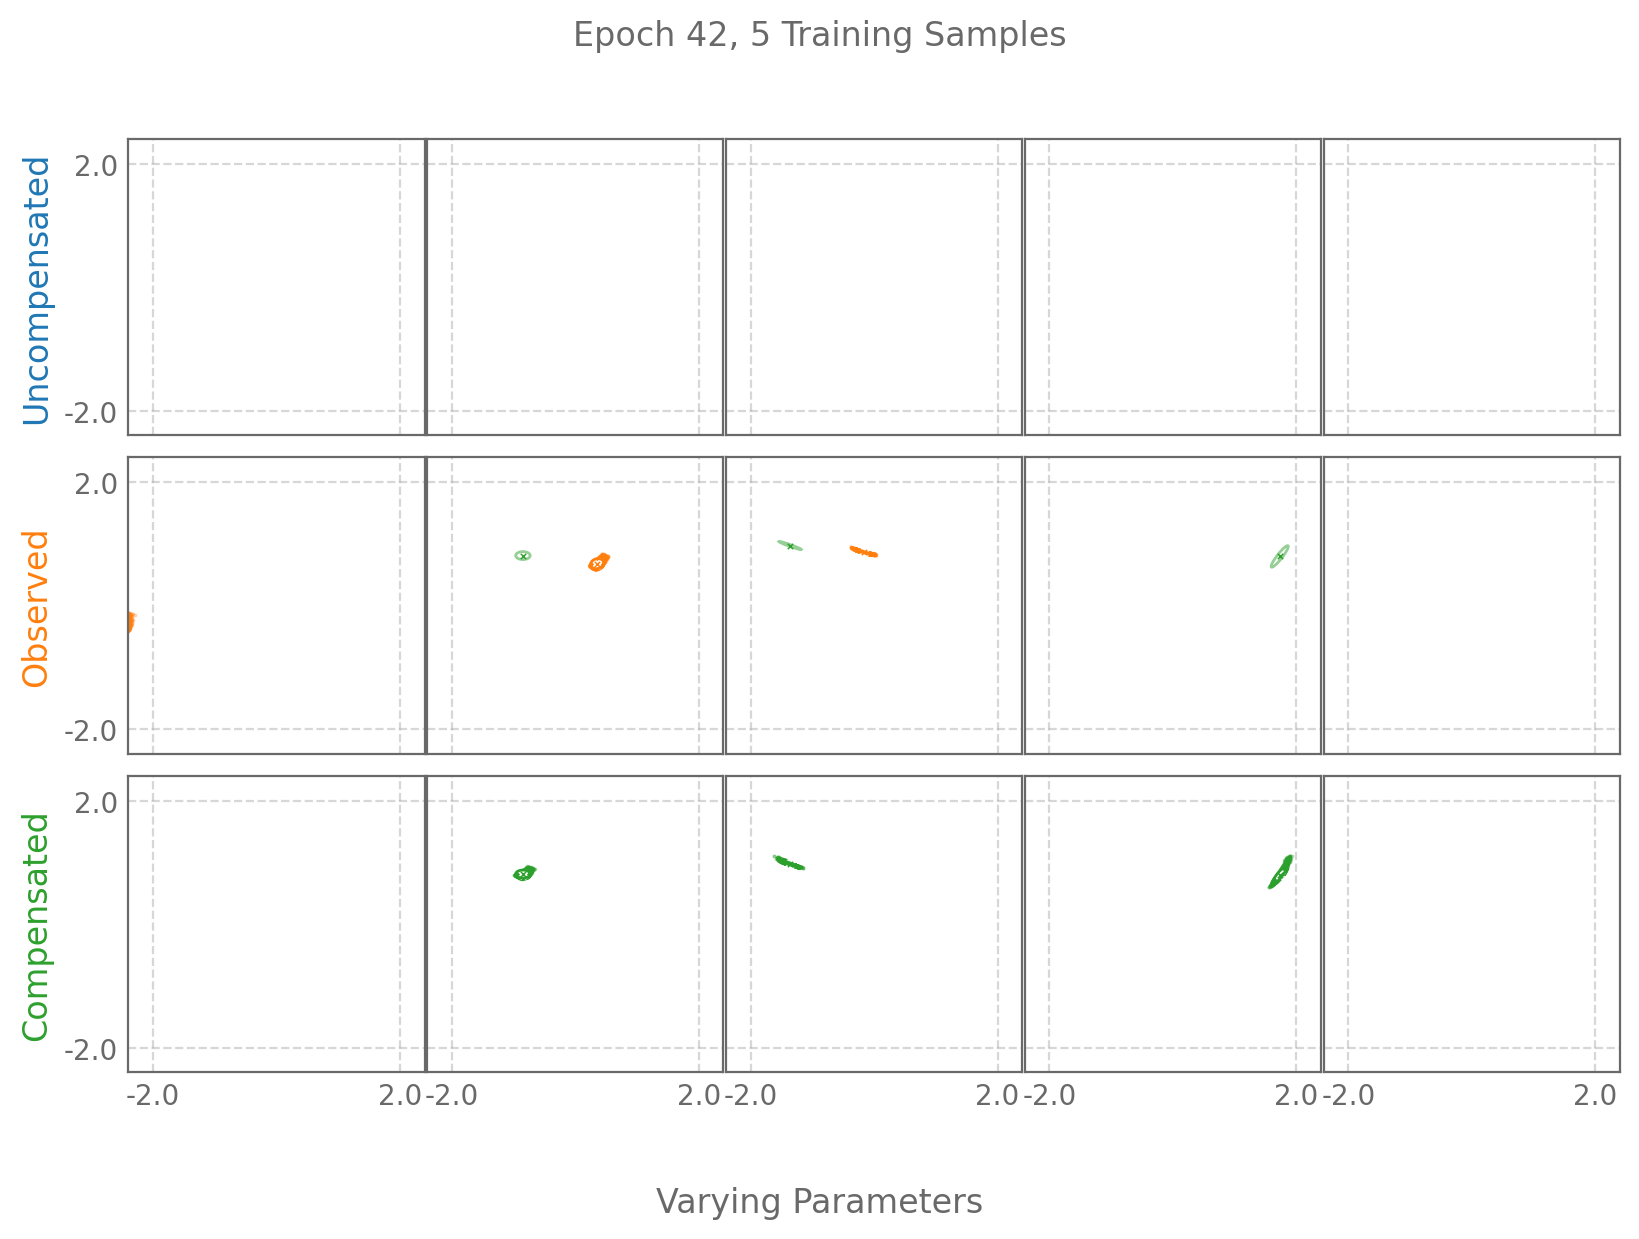

In [33]:
plot_param_tensors(loss_min_params[[1,2,3,4,7]], uncompensated_parameters_selected[[1,2,3,4,7]], compensated_parameters=compensated_parameters_selected[[1,2,3,4,7]])

# Import real data

In [14]:
def import_real_hist_data(path = 'datasets/metrix_real_data/2021_march_complete', import_set = ['M03', 'M10', 'M18', 'M22', 'M23', 'M24', 'M25', 'M27', 'M28', 'M29', 'M30', 'M32', 'M33', 'M36',
                             'M37', 'M40', 'M41', 'M42', 'M43', 'M44'], check_value_lims=False):
    imported_data = import_data(
                path,
                import_set,
                [0.],
                params(),
                check_value_lims=check_value_lims,
            )
    xy_hist = XYHistogram(50, (-10., 10.), (-3., 3.))
    
    real_data_list = []
    for i in range(len(imported_data)):
        real_data_list.append(xy_hist(imported_data[i]['ray_output']['ImagePlane']))
    
    real_data_point_cloud_list = []
    for i in range(len(imported_data)):
        real_data_point_cloud_list.append(imported_data[i])
    
    real_data_tensor = torch.stack([real_data_list[i][0.0]['histogram'] for i in range(len(real_data_list))])
    real_data_tensor_normalized = surrogate_engine.model.standardizer(real_data_tensor)
    
    uncompensated_parameters_list = []
    for i in range(len(imported_data)):
        uncompensated_entry = torch.tensor([value.get_value() for value in Plot.normalize_parameters(imported_data[i]['param_container_dict'], params()).values()])
        uncompensated_parameters_list.append(uncompensated_entry)
    uncompensated_parameters = torch.stack(uncompensated_parameters_list)
    
    observed_rays = real_data_tensor_normalized.flatten(start_dim=1).unsqueeze(1).float().to(model.device)
    uncompensated_parameters = uncompensated_parameters.unsqueeze(1).float().to(model.device)
    observed_rays_point_cloud = ray_output_to_tensor(real_data_point_cloud_list, 'ImagePlane')
    return observed_rays, uncompensated_parameters, observed_rays_point_cloud
observed_rays_real, uncompensated_parameters_real, observed_rays_point_cloud = import_real_hist_data()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.53it/s]


In [25]:
loss_min_params = optimize_smart_walker(model, observed_rays_real, uncompensated_parameters_real)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:24<00:00, 11.88it/s, loss=3.49e-5]


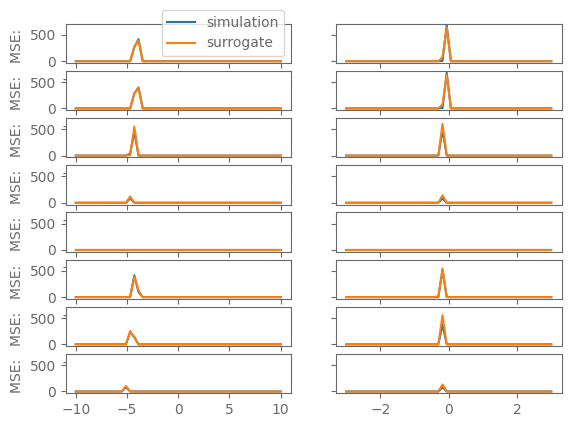

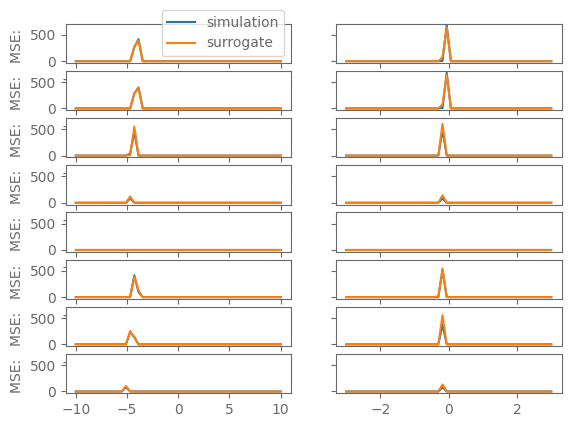

In [26]:
torch.set_default_device('cpu')
pc = [tensor_to_param_container(loss_min_params[i]) for i in range(loss_min_params.shape[0])]
Plot.plot_engines_comparison(engine, surrogate_engine, pc[:8], MultiLayer([0.]), )

In [64]:
tensor_list_to_param_container_list = lambda input_param_tensor: [tensor_to_param_container(input_param_tensor[i].squeeze()) for i in range(input_param_tensor.shape[0])]


def simulate_param_tensor(input_param_tensor):
    print("simulating", input_param_tensor.shape)
    pc = tensor_list_to_param_container_list(input_param_tensor[...,:34])
    param_container_list = []
    for i in input_param_tensor:
        i = i.squeeze()
        param_container_list.append(
            RayParameterContainer([
            ('ImagePlane.translationXerror', NumericalOutputParameter(value=(i[-2].item()-0.5)*20)),
            ('ImagePlane.translationYerror', NumericalOutputParameter(value=(i[-1].item()-0.5)*4)),
            ]))
    print("pcl",param_container_list)

    #ray_parameter_container_list = []
    #for key in ("translationXerror", "translationYerror"):
    #    ray_parameter_container_list.append(key

    #RayParameterContainer(['U41_318eV.numberRays', OutputNumericalParameter(value=33333)])
        
    exported_plain_transforms = RayOptimizer.translate_exported_plain_transforms(
        exported_plane="ImagePlane",
        param_container_list=param_container_list,
        transform = MultiLayer([0.]),
    )
    print("ept",exported_plain_transforms)
    engine_output = engine.run(pc, exported_plain_transforms)
    return ray_output_to_tensor(engine_output, 'ImagePlane')

def plot_param_tensors(best_parameters, uncompensated_parameters, observed_rays_point_cloud=None, compensated_parameters=None):
    assert observed_rays_point_cloud is not None or compensated_parameters is not None # you should provide one of two
    if compensated_parameters is not None:
        observed_rays = simulate_param_tensor(compensated_parameters)
    else:
        observed_rays = observed_rays_point_cloud
    best_rays = simulate_param_tensor(best_parameters)
    uncompensated_rays = simulate_param_tensor(uncompensated_parameters)
    
    compensation_plot = Plot.fixed_position_plot(
        best_rays,
        observed_rays,
        uncompensated_rays,
        xlim=(-2.,2.),
        ylim=(-2.,2.),
        epoch=42,
        training_samples_count=len(observed_rays),
    )

simulating torch.Size([16, 1, 36])
pcl [RayParameterContainer([('ImagePlane.translationXerror', NumericalOutputParameter: -10.0), ('ImagePlane.translationYerror', NumericalOutputParameter: -2.0)]), RayParameterContainer([('ImagePlane.translationXerror', NumericalOutputParameter: 6.151068210601807), ('ImagePlane.translationYerror', NumericalOutputParameter: -0.8032493591308594)]), RayParameterContainer([('ImagePlane.translationXerror', NumericalOutputParameter: -2.024748921394348), ('ImagePlane.translationYerror', NumericalOutputParameter: -2.0)]), RayParameterContainer([('ImagePlane.translationXerror', NumericalOutputParameter: -6.731373071670532), ('ImagePlane.translationYerror', NumericalOutputParameter: -2.0)]), RayParameterContainer([('ImagePlane.translationXerror', NumericalOutputParameter: -1.0364490747451782), ('ImagePlane.translationYerror', NumericalOutputParameter: -0.8613293170928955)]), RayParameterContainer([('ImagePlane.translationXerror', NumericalOutputParameter: -10.0)

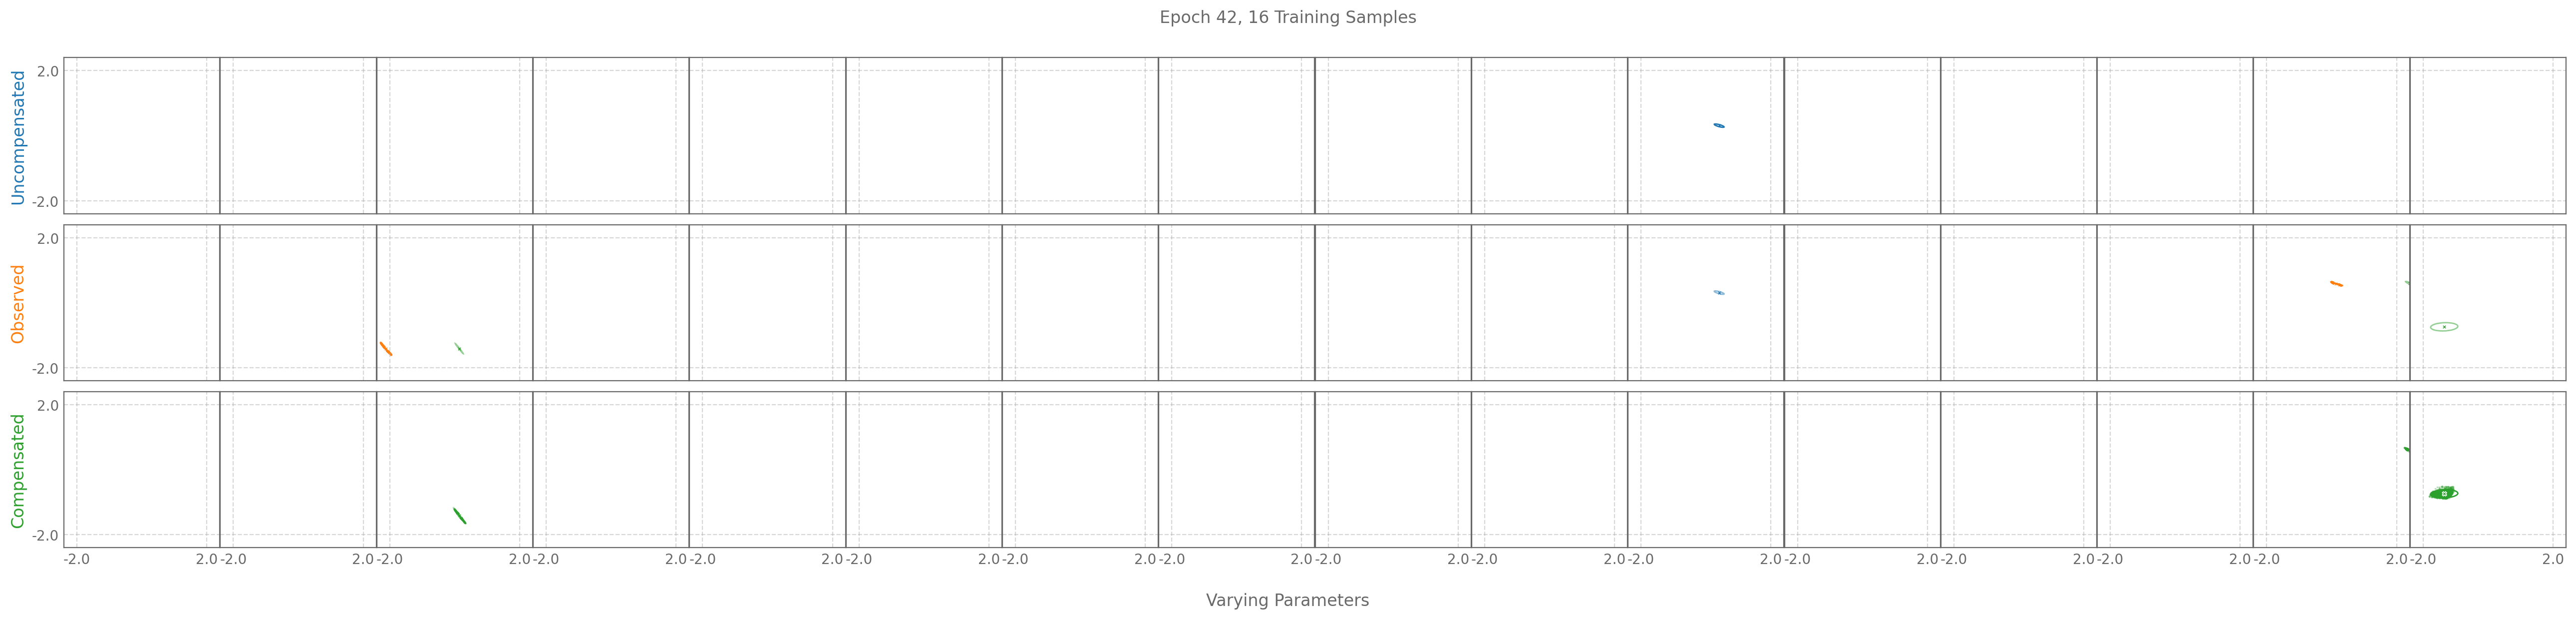

In [65]:
plot_param_tensors(loss_min_params[:], uncompensated_parameters_selected[:], compensated_parameters=compensated_parameters_selected[:])

simulating torch.Size([10, 36])
pcl [RayParameterContainer([('ImagePlane.translationXerror', NumericalOutputParameter: 0.0), ('ImagePlane.translationYerror', NumericalOutputParameter: -2.0)]), RayParameterContainer([('ImagePlane.translationXerror', NumericalOutputParameter: 0.09999990463256836), ('ImagePlane.translationYerror', NumericalOutputParameter: -2.0)]), RayParameterContainer([('ImagePlane.translationXerror', NumericalOutputParameter: 0.19999980926513672), ('ImagePlane.translationYerror', NumericalOutputParameter: -2.0)]), RayParameterContainer([('ImagePlane.translationXerror', NumericalOutputParameter: 0.2999997138977051), ('ImagePlane.translationYerror', NumericalOutputParameter: -2.0)]), RayParameterContainer([('ImagePlane.translationXerror', NumericalOutputParameter: 0.39999961853027344), ('ImagePlane.translationYerror', NumericalOutputParameter: -2.0)]), RayParameterContainer([('ImagePlane.translationXerror', NumericalOutputParameter: 0.4999995231628418), ('ImagePlane.tran

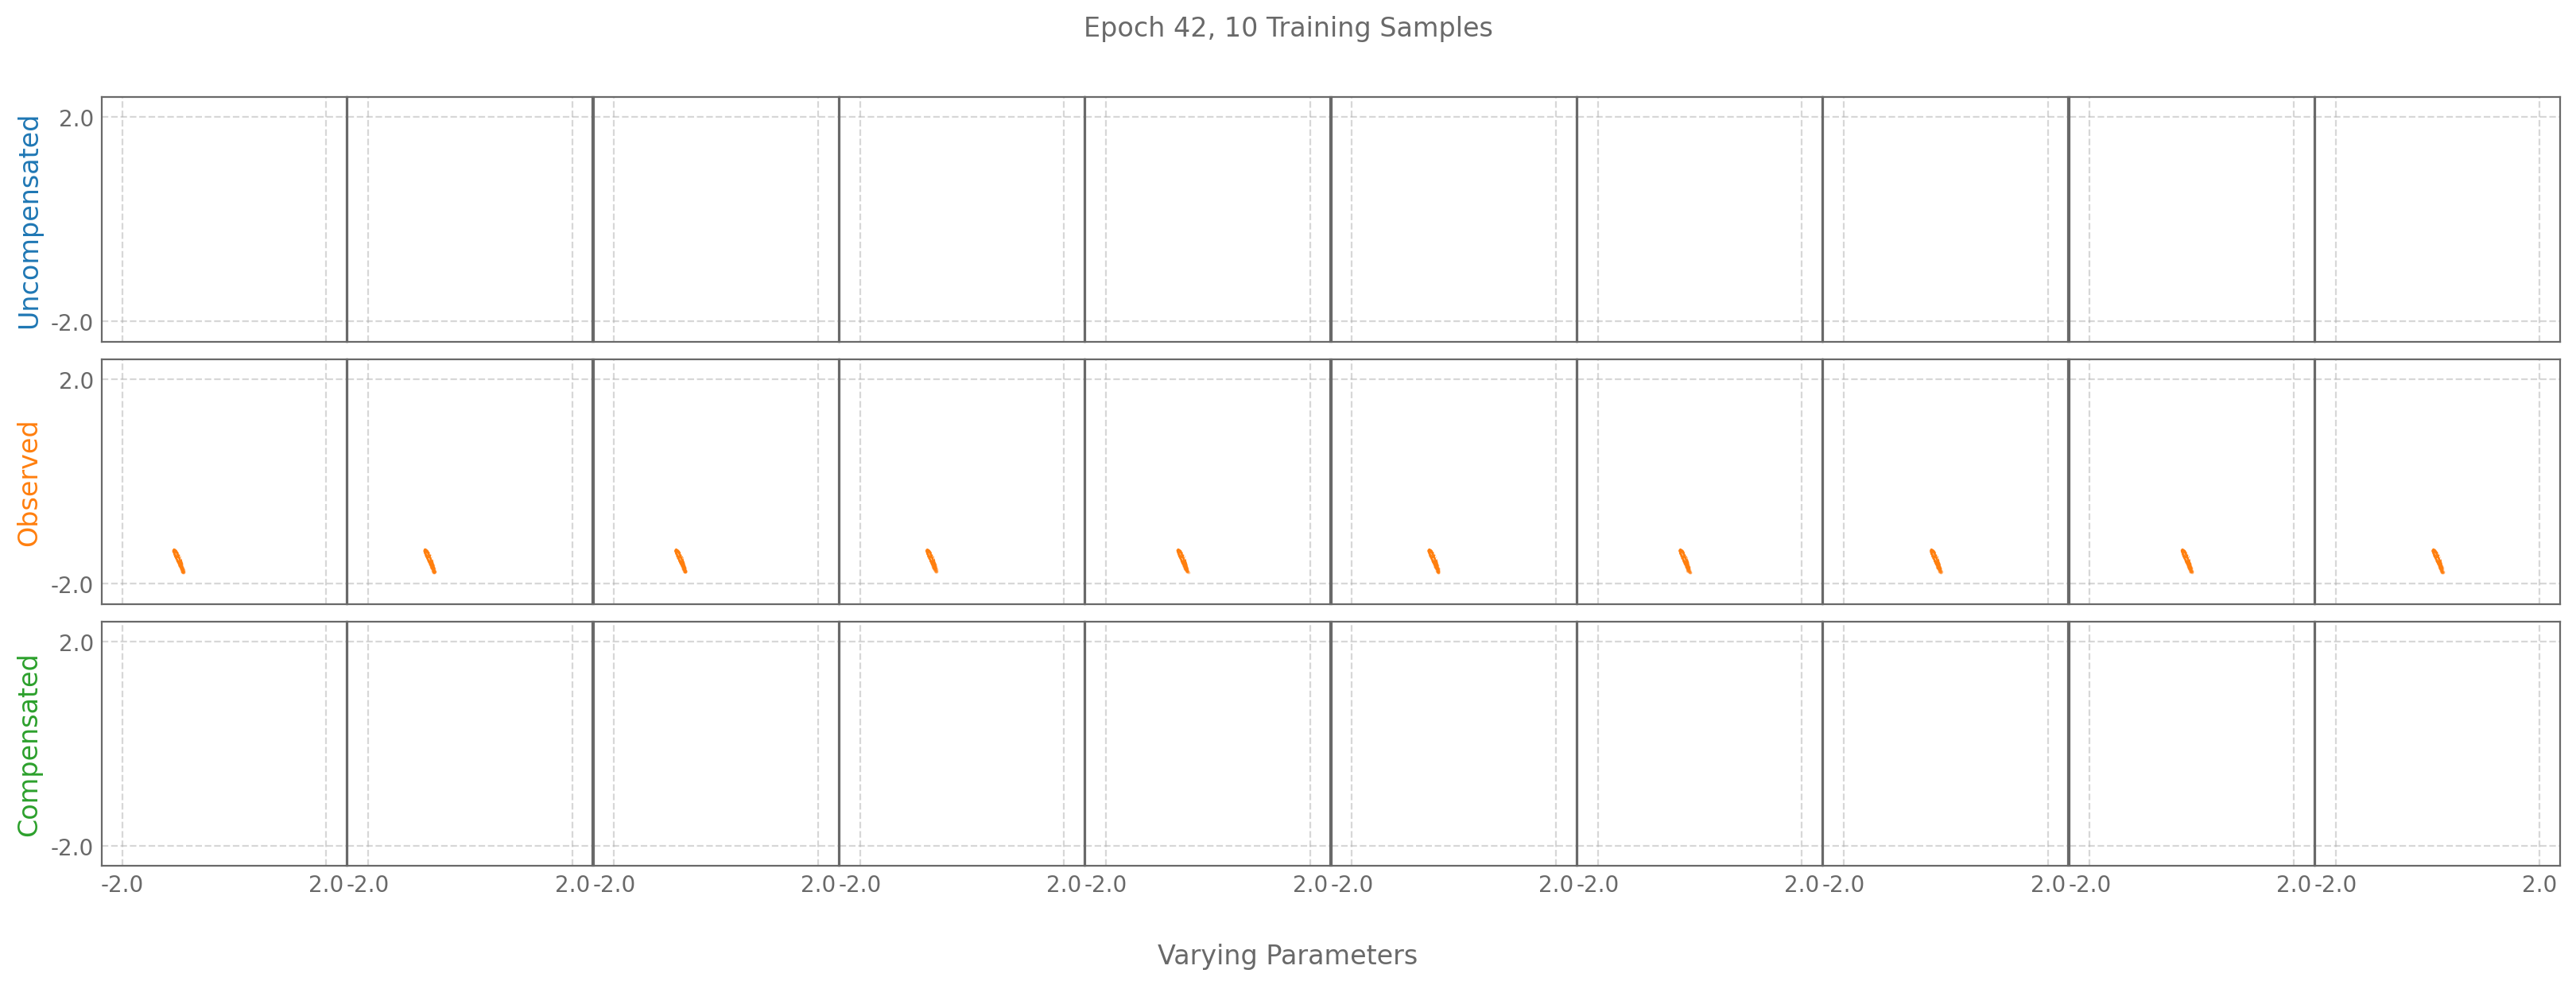

In [70]:
repeated_params = torch.vstack(10*[loss_min_params[1]])
a = repeated_params.clone()
b = repeated_params.clone()
c = repeated_params.clone()
for i, ten in enumerate(a):
    ten[-1]=0.5+0.001*i
    ten[-2]=0.
for i, ten in enumerate(b):
    ten[-2]=0.
    ten[-1]=0.5+0.005*i
for i, ten in enumerate(c):
    ten[-1]=0.
    ten[-2]=0.5+0.005*i
plot_param_tensors(a[:], b[:], compensated_parameters=c[:])
#print(repeated_params)
#plot_param_tensors(loss_min_params[:], uncompensated_parameters_selected[:], compensated_parameters=compensated_parameters_selected[:])

In [55]:
loss_min_params.shape, uncompensated_parameters_selected.shape, compensated_parameters_selected.shape

(torch.Size([16, 36]), torch.Size([16, 1, 36]), torch.Size([16, 1, 36]))

In [ ]:
parameter_comparison_plot = Plot.plot_param_comparison(
    predicted_params=tensor_list_to_param_container_list(loss_min_params.squeeze().unsqueeze(0)),
    epoch=42,
    training_samples_count=len(observed_rays),
    search_space=params(),
    real_params=tensor_list_to_param_container_list(compensated_parameters_selected)[0],
)

In [ ]:
parameter_comparison_plot = Plot.plot_param_comparison(
    predicted_params=tensor_to_param_container(offsets_selected.squeeze()),
    epoch=42,
    training_samples_count=len(observed_rays),
    search_space=RayOptimization.limited_search_space(params(), RandomGenerator(42), max_deviation=max_offset),
    real_params=tensor_list_to_param_container_list(loss_min_params[0] - compensated_parameters_selected.squeeze())[1],
)

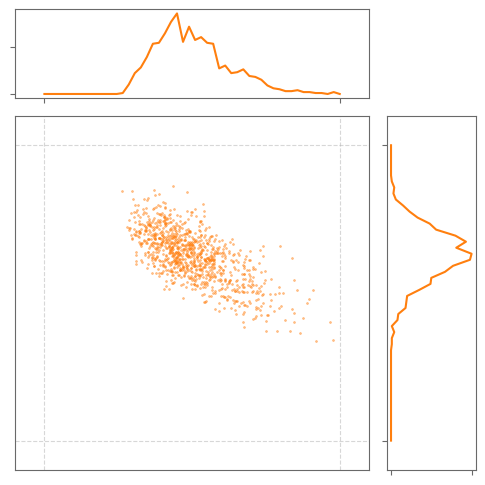

In [11]:
import matplotlib.pyplot as plt
from matplotlib import transforms
import numpy as np
from matplotlib.layout_engine import ConstrainedLayoutEngine, TightLayoutEngine
from matplotlib.ticker import NullLocator
from matplotlib.ticker import FormatStrFormatter

rs = np.random.RandomState(11)
x = rs.gamma(4, size=1000)
y = -.5 * x + rs.normal(size=1000)
x = x / 4  -1
y = y/4 +1


def scatter_hist(x, y, ax, ax_histx, ax_histy):
    xlim_min, xlim_max, ylim_min, ylim_max = -2, 2, -2, 2
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    color = plt.rcParams["axes.prop_cycle"].by_key()["color"][1]
    ax.scatter(
    x,
    y,
    s=2.0,
    alpha=0.5,
    linewidths=0.4,
    color=color
    )
    ax.set_xlim(
    Plot.scale_interval(
        xlim_min, xlim_max, 1.2
    )
)
    ax.set_ylim(
        Plot.scale_interval(
            ylim_min, ylim_max, 1.2
        )
    )
    ax.tick_params(axis="both", length=0.0)
    ax.grid(linestyle="dashed", alpha=0.5)
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    
    ax.set_xticks((xlim_min, xlim_max))
    ax.set_yticks((ylim_min, ylim_max))
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    #ax_histx.hist(x, bins=bins, color=color)
    x_simulation_hist, _ = torch.histogram(torch.from_numpy(x),bins=50, range=[-2, 2])
    ax_histx.plot(torch.linspace(-2, 2, 50), x_simulation_hist, color=color)
    ax_histx.set_yticklabels([])
    #ax_histy.hist(y, bins=bins, orientation='horizontal', color=color)
    y_simulation_hist, _ = torch.histogram(torch.from_numpy(y),bins=50, range=[-2, 2])
    ax_histy.plot(y_simulation_hist, torch.linspace(-2, 2, 50), color=color)
    ax_histy.set_xticklabels([])


# Create a Figure, which doesn't have to be square.
fig = plt.figure(layout='constrained')
# Create the main Axes, leaving 25% of the figure space at the top and on the
# right to position marginals.
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
# The main Axes' aspect can be fixed.
ax.set(aspect=1)
# Create marginal Axes, which have 25% of the size of the main Axes.  Note that
# the inset Axes are positioned *outside* (on the right and the top) of the
# main Axes, by specifying axes coordinates greater than 1.  Axes coordinates
# less than 0 would likewise specify positions on the left and the bottom of
# the main Axes.
ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(x, y, ax, ax_histx, ax_histy)

plt.show()


# Evotorch

In [ ]:
from evotorch import Problem
from evotorch.algorithms import SNES
from evotorch.logging import StdOutLogger

def norm(x: torch.Tensor) -> torch.Tensor:
  return torch.linalg.norm(x, dim=-1)

with torch.no_grad():
    observed_rays = model(compensated_parameters_selected)
uncompensated_parameters = uncompensated_parameters_selected
def loss(x: torch.Tensor) -> torch.Tensor:
    with torch.no_grad():
        tensor_sum = x + uncompensated_parameters
        compensated_rays = model(tensor_sum)
        compensated_rays = compensated_rays.flatten(start_dim=2)
        loss_orig = ((compensated_rays - observed_rays) ** 2).mean(0).mean(-1)
    return loss_orig

problem = Problem(
  "min",
  loss,
  initial_bounds=(0., 1.),
  solution_length=36,
  vectorized=True,
  device="cuda",  # Enable for GPU support
)

searcher = SNES(problem, popsize=1000, stdev_init=0.2)
_ = StdOutLogger(searcher, interval=100)

searcher.run(num_generations=5000)

# SGD

In [28]:
batch_size = 10000
x = torch.rand((batch_size, 36), requires_grad=True, device=model.device)
optimizer = torch.optim.SGD([x], lr=0.01)  # Adjust the learning rate as needed
torch.autograd.set_detect_anomaly(True)
num_epochs = 1000  # Number of iterations
uncompensated_parameters = uncompensated_parameters_selected
#with torch.no_grad():
observed_rays = model(compensated_parameters_selected)

def function_to_minimize(x):
    tensor_sum = x + uncompensated_parameters
    compensated_rays = model(tensor_sum)
    compensated_rays = compensated_rays.flatten(start_dim=2)
    loss_orig = ((compensated_rays - observed_rays) ** 2).mean(0).mean(-1)
    return loss_orig

pbar = tqdm.trange(num_epochs)
for epoch in pbar:
    optimizer.zero_grad()  # Clear the gradients from the previous step
    
    output = function_to_minimize(x.detach())  # Compute the function's output
    loss = output.mean()  # Compute the mean loss for this batch
    
    loss.backward(retain_graph=True)  # Backpropagate to compute the gradients
    optimizer.step()  # Update the parameters with SGD
    
    # Optionally print the loss to monitor progress
    if epoch % 100 == 0:
        pbar.set_postfix({"loss": loss.item()})

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.64it/s, loss=0.0127]
